## Introduction

The rapid growth of data collection has led to a new era of information. Data is being used to create more efficient systems and this is where Recommendation Systems come into play. Recommendation Systems are a type of information filtering systems as they improve the quality of search results and provides items that are more relevant to the search item or are realted to the search history of the user.

They are used to predict the rating or preference that a user would give to an item. Almost every major tech company has applied them in some form or the other: Amazon uses it to suggest products to customers, YouTube uses it to decide which video to play next on autoplay, and Facebook uses it to recommend pages to like and people to follow. Moreover, companies like Netflix and Spotify depend highly on the effectiveness of their recommendation engines for their business and sucees.

There are mainly three types of recommender systems:

- **Demographic Recommender**
   - It offers generalized recommendations to every user, based on movie popularity. This system recommends the same movies with similar demographic features to all users and it does not give personalized recommendations to users. 


- **Content-Based Recommender**
    - It builds an engine that computes similarity between movies based on certain metrics (such as genre, director, description, actors, etc.) and suggests movies that are most similar to a particular movie that a user liked. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.

- **Collaborative Recommender**
   - This system matches persons with similar interests and provides recommendations based on this matching. Collaborative filtering is based on the idea that users similar to a particular user can be used to predict how much that particular user will like a particular product or service those users have used/experienced but that particular user has not. 

In this notebook, we will use MovieLens datasets and implement three recommendation algorithms including Demographic, Content-Based and Collaborative Filtering, and finally try to build an ensemble of these models to come up with our final Hybrid ecommendation system.


**The MovieLens datasets include**:
- "tmdb_5000_credits" which contains the following features:

   -  movie_id - A unique identifier for each movie.
   -  title - Title of each movie.
   -  cast - The name of lead and supporting actors.
   -  crew - The name of Director, Editor, Composer, Writer etc.
   
   
- "tmdb_5000_movies" which contains the following features:
  - budget - The budget in which the movie was made.
  - genre - The genre of the movie, Action, Comedy ,Thriller etc.
  - homepage - A link to the homepage of the movie.
  - id - This is in fact the movie_id as in the first dataset.
  - keywords - The keywords or tags related to the movie.
  - original_language - The language in which the movie was made.
  - original_title - The title of the movie before translation or adaptation.
  - overview - A brief description of the movie.
  - popularity - A numeric quantity specifying the movie popularity.
  - production_companies - The production house of the movie.
  - production_countries - The country in which it was produced.
  - release_date - The date on which it was released.
  - revenue - The worldwide revenue generated by the movie.
  - runtime - The running time of the movie in minutes.
  - status - "Released" or "Rumored".
  - tagline - Movie's tagline.
  - title - Title of the movie.
  - vote_average - average ratings the movie recieved.
  - vote_count - the count of votes recieved.
  

- "ratings_small" which contains the following features:
  - userId - A unique identifier for each user.
  - movieId - A unique identifier for each movie. 
  - rating - The rating given by the user for each movie.
  - timestamp - The time when rating was recorded.
  

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import SVD, Reader, Dataset 
from surprise.model_selection import cross_validate

## Loading Datasets

In [2]:
df_credits=pd.read_csv('tmdb_5000_credits.csv')

In [3]:
df_credits.head(2)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [4]:
df_movies=pd.read_csv('tmdb_5000_movies.csv')

In [5]:
df_movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


Now we join these two dataset on the 'id' column. As both dataframes contain a 'title' column, we remove on of the title columns.

In [6]:
df_credits.columns=['id', 'title', 'cast', 'crew']

In [7]:
df_movies.drop(['title'], axis=1, inplace=True)

In [8]:
df_movielens=pd.merge(df_credits,df_movies,on='id')

In [9]:
df_movielens.head(2)

,id,title,cast,crew,budget,genres,homepage,keywords,original_language,original_title,...,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,...,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,...,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",6.9,4500


In [10]:
df_movielens.shape

(4803, 22)

## Demographic Recommender 

The implementation of Demographic Filtering is straighforward. All we have to do is sort our movies based on ratings, and display the top movies of our list. Therefore, we should;

- Create a metric to score or rate the movies.
- Calculate the score for every movie
- Sort the scores and recommend the best rated movie to the users.

We can use the average ratings of the movie as the score but using this will not be fair enough since a movie with 8.9 average rating and only 3 votes cannot be considered better than the movie with 7.8 as as average rating but 40 votes. So, we use IMDB's weighted rating formula to score the movies, as follows:

Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$ 

- v: the number of votes for the movie

- m: the minimum votes required to be listed in the chart

- R: the average rating of the movie

- C: the mean vote across the whole report

We already have v or 'vote_count' column, and R or 'vote_average' column. So we calculate C.

In [11]:
df_movielens['vote_average'].mean()

6.092171559442011

The mean rating for all the movies is approximately 6 on a scale of 10.

The next step is to determine an appropriate value for m, the minimum number of votes required for a movie to be listed in the chart. We use 90th percentile as our cutoff. In other words, for a movie to feature in the charts, the number of its votes should be higher than that of 90% of the movies in the list.

In [12]:
df_movielens['vote_count'].quantile(q=0.9)

1838.4000000000015

Now, we filter the movies that qualify for the chart and put them in a new dataframe called df_filtered.

In [13]:
df_filtered=df_movielens[df_movielens['vote_count']>df_movielens['vote_count'].quantile(q=0.9)]

In [14]:
df_filtered.shape

(481, 22)

We see that there are 481 movies which qualify to be in this list.

Now, we calculate score for each qualified movie. To do this, we define a function, weighted_rating(), and apply this function to the DataFrame of qualified movies.

In [15]:
def movie_score(x):
    v=x['vote_count']
    m=df_movielens['vote_count'].quantile(q=0.9)
    R=x['vote_average']
    C=df_movielens['vote_average'].mean()
    return ((R*v)/(v+m))+((C*m)/(v+m))

In [16]:
df_filtered['score']=df_filtered.apply(movie_score, axis=1)

C:\Users\Soha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Finally, we sort the dataframe based on the score feature. Then we output the title, genres, vote count, vote average, popularity and score of the top 10 movies.

In [17]:
df_highscore=df_filtered.sort_values(by='score', ascending=False).head(10)

In [18]:
df_highscore[['title', 'vote_count', 'vote_average', 'popularity', 'score']]

,title,vote_count,vote_average,popularity,score
1881,The Shawshank Redemption,8205,8.5,136.747729,8.059258
662,Fight Club,9413,8.3,146.757391,7.939256
65,The Dark Knight,12002,8.2,187.322927,7.920020
3232,Pulp Fiction,8428,8.3,121.463076,7.904645
96,Inception,13752,8.1,167.583710,7.863239
3337,The Godfather,5893,8.4,143.659698,7.851236
95,Interstellar,10867,8.1,724.247784,7.809479
809,Forrest Gump,7927,8.2,138.133331,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,123.630332,7.727243
1990,The Empire Strikes Back,5879,8.2,78.517830,7.697884


So we made a demographic recommender. To find the movies that are very popular, we sort the dataset by the 'popularity' column.

In [19]:
df_popular= df_movielens.sort_values('popularity', ascending=False).head(10)

In [20]:
df_popular[['title', 'vote_count', 'vote_average', 'popularity']]

,title,vote_count,vote_average,popularity
546,Minions,4571,6.4,875.581305
95,Interstellar,10867,8.1,724.247784
788,Deadpool,10995,7.4,514.569956
94,Guardians of the Galaxy,9742,7.9,481.098624
127,Mad Max: Fury Road,9427,7.2,434.278564
28,Jurassic World,8662,6.5,418.708552
199,Pirates of the Caribbean: The Curse of the Bla...,6985,7.5,271.972889
82,Dawn of the Planet of the Apes,4410,7.3,243.791743
200,The Hunger Games: Mockingjay - Part 1,5584,6.6,206.227151
88,Big Hero 6,6135,7.8,203.734590


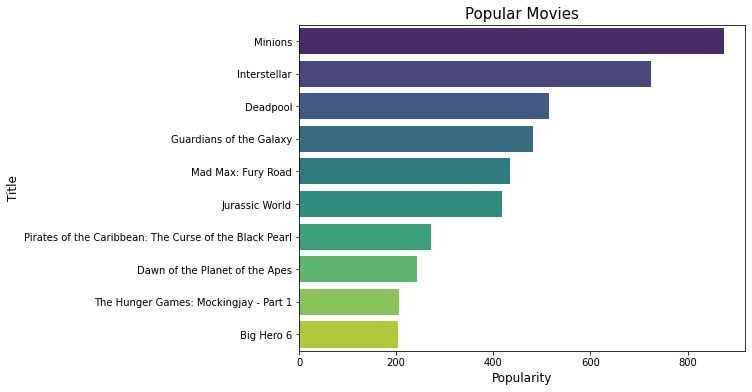

In [21]:
plt.figure(figsize=(8,6))
sns.barplot(y='title',x='popularity', data=df_popular, palette='viridis')
plt.xlabel("Popularity", fontsize=12)
plt.ylabel("Title", fontsize=12)
plt.title("Popular Movies", fontsize=15)
plt.show()

We should keep in mind that this demographic recommender provide a general chart of recommended movies to all the users, regardless of the user's personal taste. It is not sensitive to the interests and tastes of a particular user, and it does not give personalized recommendations based on the users.

## Content-Based Recommender

To personalize the recommendations, we build an engine that computes similarity between movies based on certain metrics and suggests movies that are most similar to a particular movie that a user liked. 

We build two Content-Based Recommenders based on contents including:

- Movie Overview 
- Movie Cast, Crew, Keywords and Genre

### Movie Overview Based Recommender

First we compute pairwise similarity scores for all movies based on their 'overview' column. Then recommend movies based on that similarity score.

In [22]:
df_movielens['overview']

0       In the 22nd century, a paraplegic Marine is di...
1       Captain Barbossa, long believed to be dead, ha...
2       A cryptic message from Bond’s past sends him o...
3       Following the death of District Attorney Harve...
4       John Carter is a war-weary, former military ca...
                              ...                        
4798    El Mariachi just wants to play his guitar and ...
4799    A newlywed couple's honeymoon is upended by th...
4800    "Signed, Sealed, Delivered" introduces a dedic...
4801    When ambitious New York attorney Sam is sent t...
4802    Ever since the second grade when he first saw ...
Name: overview, Length: 4803, dtype: object

We replace NaN in 'overview' column with an empty string.

In [23]:
df_movielens['overview'].isnull().sum()

3

In [24]:
df_movielens['overview'].fillna(' ', inplace=True)

Now we compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each overview.

Term Frequency (TF) is the relative frequency of a word in a document and is given as (term instances/total instances). Inverse Document Frequency (IDF) is the relative count of documents containing the term and is given as log(number of documents/documents with term). The overall importance of each word to the documents in which they appear is equal to TF * IDF

This gives us a matrix where each column represents a word in the overall overview vocabulary and each row represents a movie.This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.

Scikit-learn has a built-in TfIdfVectorizer class that produces the TF-IDF matrix in a couple of lines.

#### Constructing TF-IDF Matrix 

In [25]:
tfidfv=TfidfVectorizer(analyzer='word', stop_words='english')
tfidfv_matrix=tfidfv.fit_transform(df_movielens['overview'])
print(tfidfv_matrix.todense())
tfidfv_matrix.todense().shape

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(4803, 20978)

We see that over 20,000 different words were used to describe the 4803 movies in our dataset.

#### Computing Similarity Score

We can compute the similarity score by different methods such as euclidean, Pearson and cosine similarity. We choose the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies because it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:

$cosine(x,y) = \frac{x. y^\intercal}{||x||.||y||} $


Since we have used the TfidfVectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's **linear_kernel** instead of cosine_similarities since it is faster.

In [26]:
cosine_sim1 = linear_kernel(tfidfv_matrix, tfidfv_matrix)

In [27]:
cosine_sim1.shape 

(4803, 4803)

We now have a pairwise cosine similarity matrix for all the movies in our dataset. 

#### Defining Recommendation Function

The next step is to define a recommendation function that takes in a movie title as an input and outputs a list of the 10 most similar movies. In order to do this;

- We need a reverse mapping of movie titles and dataframe indices. In other words, we build a series to identify the index of a movie in our dataframe, given its title.

- The function should get the index of the movie given its title.

- Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.

- Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.

- Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).

- Return the titles corresponding to the indices of the top elements.

In [28]:
indices=pd.Series(data=list(df_movielens.index), index= df_movielens['title'] )

In [29]:
indices

title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64

In [30]:
# Function that takes in movie title as input and outputs most similar movies
def content_recommendations(title, cosine_sim):
    
    # Get the index of the movie that matches the title
    idx = indices[title]
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on the similarity scores
    sim_scores.sort(key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores=sim_scores[1:11]
    
    # Get the movie indices
    ind=[]
    for (x,y) in sim_scores:
        ind.append(x)
        
    # Return the top 10 most similar movies
    tit=[]
    for x in ind:
        tit.append(df_movielens.iloc[x]['title'])
    return pd.Series(data=tit, index=ind)

In [31]:
content_recommendations('The Dark Knight Rises',cosine_sim1)

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
dtype: object

In [32]:
content_recommendations('The Avengers',cosine_sim1)

7               Avengers: Age of Ultron
3144                            Plastic
1715                            Timecop
4124                 This Thing of Ours
3311              Thank You for Smoking
3033                      The Corruptor
588     Wall Street: Money Never Sleeps
2136         Team America: World Police
1468                       The Fountain
1286                        Snowpiercer
dtype: object

While our system has done a decent job of finding movies with similar overviews and descriptions, the quality of recommendations is not that great. "The Dark Knight Rises" returns all Batman movies while it is more likely that the people who liked that movie are more inclined to enjoy other Christopher Nolan movies. This is something that cannot be captured by the present system.

### Movie Cast, Crew, Keywords, Genres Based Recommender

In order to improve the quality of the content-based recommender, we use better metadata. So we build a recommender based on the following metadata: 
- the director
- the 3 top actors
- the 3 top related genres 
- the 3 top movie plot keywords

From the crew, cast, genres and keywords features, we need to extract the the director, and the three most important actors, genres and keywords associated with that movie. 

#### Preprocessing the Contents

##### Applying literal_eval Function on Stringified Lists

Right now, our data in 'crew', 'cast', 'genres' and 'keywords' columns is present in the form of "stringified" lists. So we need to convert it into a safe and usable structure. literal_eval is a function which evaluates a string as though it were an expression and returns a result.

In [33]:
type(df_movielens['cast'].iloc[0])

str

In [34]:
features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df_movielens[feature] = df_movielens[feature].apply(literal_eval)

In [35]:
type(df_movielens['cast'].iloc[0])

list

##### Defining Functions to Grab the Contents

In [36]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for a in x:
        if a['job']=='Director':
            return a['name'] 
    return 'NaN'

In [37]:
# Get the list top 3 elements or entire list; whichever is more in cast, genres and keywords columns.
def get_top3(x):
    new=[]
    for a in x[:3]:
        new.append(a['name']) 
    return new
#Return empty list in case of missing/malformed data
    return []

Now we define new director, actor, genres and keywords columns.

In [38]:
df_movielens['director']=df_movielens['crew'].apply(lambda x: get_director(x))

In [39]:
df_movielens['actor']=df_movielens['cast'].apply(lambda x:get_top3(x))

In [40]:
df_movielens['genres']=df_movielens['genres'].apply(lambda x:get_top3(x))

In [41]:
df_movielens['keywords']=df_movielens['keywords'].apply(lambda x:get_top3(x))

In [42]:
df_movielens[['title', 'actor', 'director', 'keywords', 'genres']].head(3)

,title,actor,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


The next step would be to convert the names and keyword instances into lowercase and strip all the spaces between them. This is done so that our vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same.

In [43]:
def clean_director(x):
    return x.lower().replace(' ','')

In [44]:
def clean_top3(x):
    new=[]
    for a in x:
        new.append(a.lower().replace(' ',''))
    return new

Now we apply these clean functions on director, actor, genres and keywords columns.

In [45]:
df_movielens['director']=df_movielens['director'].apply(lambda x: clean_director(x))

In [46]:
df_movielens['actor']=df_movielens['actor'].apply(lambda x:clean_top3(x))

In [47]:
df_movielens['keywords']=df_movielens['keywords'].apply(lambda x:clean_top3(x))

In [48]:
df_movielens['genres']=df_movielens['genres'].apply(lambda x:clean_top3(x))

In [49]:
df_movielens[['title', 'actor', 'director', 'keywords', 'genres']].head(3)

,title,actor,director,keywords,genres
0,Avatar,"[samworthington, zoesaldana, sigourneyweaver]",jamescameron,"[cultureclash, future, spacewar]","[action, adventure, fantasy]"
1,Pirates of the Caribbean: At World's End,"[johnnydepp, orlandobloom, keiraknightley]",goreverbinski,"[ocean, drugabuse, exoticisland]","[adventure, fantasy, action]"
2,Spectre,"[danielcraig, christophwaltz, léaseydoux]",sammendes,"[spy, basedonnovel, secretagent]","[action, adventure, crime]"


Now we create the 'soup' column, that contains all the metadata that we want to feed to our vectorizer (namely actors, director, genres and keywords).

In [50]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['actor']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

In [51]:
df_movielens['soup'] = df_movielens.apply(create_soup, axis=1)

#### Constructing TF-IDF Matrix 

The next steps are the same as what we did with our Movie Overview Based Recommender. One important difference is that we use the CountVectorizer() instead of TF-IDF. This is because we do not want to down-weight the presence of an actor/director if he or she has acted or directed in relatively more movies.

In [52]:
cv = CountVectorizer(stop_words='english')
cv_matrix = cv.fit_transform(df_movielens['soup'])

#### Computing Similarity Score

Since we have used Countvectorizer, we use **cosine_similarities** to compute the similarity score.

In [53]:
cosine_sim2 = cosine_similarity(cv_matrix, cv_matrix)

#### Applying Recommendation Function

We can now reuse our content_recommendations function by passing in the new cosine_sim2 matrix as the second argument.

In [54]:
content_recommendations('The Dark Knight Rises', cosine_sim2)

65               The Dark Knight
119                Batman Begins
4638    Amidst the Devil's Wings
1196                The Prestige
3073           Romeo Is Bleeding
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
747               Gangster Squad
dtype: object

In [55]:
content_recommendations('The Godfather', cosine_sim2)

867      The Godfather: Part III
2731      The Godfather: Part II
2649           The Son of No One
1525              Apocalypse Now
4638    Amidst the Devil's Wings
1018             The Cotton Club
1170     The Talented Mr. Ripley
1209               The Rainmaker
1394               Donnie Brasco
1850                    Scarface
dtype: object

We see that our recommender has been successful in capturing more information due to more metadata and has given us better recommendations. It is more likely that Marvels or DC comics fans will like the movies of the same production house. Therefore, to our features above we can add production_company . We can also increase the weight of the director , by adding the feature multiple times in the soup.

## Collaborative Recommender

Our content-based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it does not capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who she/he is.

Therefore, in this section, we will use a technique called **Collaborative Filtering** to make recommendations to Movie Watchers.

Collaborative Filtering matches persons with similar interests and provides recommendations based on this matching. It is based on the idea that users similar to me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not. This system does not require item metadata like its content-based counterparts.

**Surprise** library is a Python scikit for building and analyzing recommender systems that deal with explicit rating data. Here we use the Surprise library that uses extremely powerful algorithms like **Singular Value Decomposition (SVD)** to minimise Root Mean Square Error (RMSE) that is measured by **Kfold Cross Validation** and give great recommendations.

In [56]:
from surprise import SVD, Reader, Dataset 
from surprise.model_selection import cross_validate

In [57]:
df_rating= pd.read_csv('ratings_small.csv')
df_rating.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Note that in this dataset, movies are rated on a scale of 5 unlike 'vote_average' column in df_movielens.

### SVD: Matrix Factorization Based Algorithm

In [58]:
# We will use the famous SVD algorithm.
svd = SVD()

In [59]:
reader = Reader()

In [60]:
# Load the ratings_small dataset (download it if needed),
data = Dataset.load_from_df(df_rating[['userId', 'movieId', 'rating']], reader)

In [61]:
# Run 5-fold cross-validation and print the results
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8867  0.9034  0.9008  0.8887  0.9019  0.8963  0.0071  
MAE (testset)     0.6849  0.6937  0.6974  0.6828  0.6930  0.6904  0.0056  
Fit time          8.08    5.42    5.24    5.80    5.87    6.08    1.03    
Test time         0.26    0.16    0.22    0.16    0.22    0.20    0.04    


{'test_rmse': array([0.88668293, 0.9033601 , 0.90076366, 0.88867809, 0.90186257]),
 'test_mae': array([0.68490077, 0.69372103, 0.69742899, 0.68281255, 0.69295854]),
 'fit_time': (8.082488775253296,
  5.421875238418579,
  5.235727071762085,
  5.799577236175537,
  5.865559816360474),
 'test_time': (0.26284122467041016,
  0.16219377517700195,
  0.22410106658935547,
  0.15508079528808594,
  0.21796298027038574)}

We get a mean Root Mean Sqaure Error of 0.89 approx which is good enough for our case. Let us now train on our dataset and arrive at predictions.

In [62]:
#sample full trainset
trainset = data.build_full_trainset()

In [63]:
# Train the algorithm on the trainset
svd.fit(trainset)

Let us pick user with user Id 1 and check the ratings she/he has given.


In [64]:
df_rating[df_rating['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


We use the algorithm to predict his/her score for move_id of 302.

In [65]:
# predict ratings for the testset
svd.predict(uid=1, iid=302, r_ui=None)

Prediction(uid=1, iid=302, r_ui=None, est=2.6143174984148856, details={'was_impossible': False})

In [66]:
# directly grab the estimated ratings for the testset
svd.predict(uid=1, iid=302, r_ui=None).est

2.6143174984148856

For movie with ID 302, we get an estimated prediction of 2.63. One startling feature of this recommender system is that it does not care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

## Hybrid Recommender

In this section, we try to build a simple hybrid recommender that brings together techniques we have implemented in the content-based and collaborative filter based engines. This is how it works:

- Input: User ID and the Title of a Movie

- Output: Similar movies sorted on the basis of expected ratings by that particular user.

In [67]:
df_movielens.columns=['movieId', 'title', 'cast', 'crew', 'budget', 'genres', 'homepage',
       'keywords', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'vote_average', 'vote_count', 'director', 'actor', 'soup']

In [68]:
# Function that takes in movie title as input and outputs most similar movies
def hybrid_recommendations(userId, title):
    
    # Get the index of the movie that matches the title
    idx = indices[title]
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim2[idx]))
    
    # Sort the movies based on the similarity scores
    sim_scores.sort(key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores=sim_scores[1:11]
    
    # Get the movie indices
    ind=[]
    for (x,y) in sim_scores:
        ind.append(x)
        
    # Grab the title,movieid,vote_average and vote_count of the top 10 most similar movies
    tit=[]
    movieid=[]
    vote_average=[]
    vote_count=[]
    for x in ind:
        tit.append(df_movielens.iloc[x]['title'])
        movieid.append(df_movielens.iloc[x]['movieId'])
        vote_average.append(df_movielens.iloc[x]['vote_average'])
        vote_count.append(df_movielens.iloc[x]['vote_count'])

        
    # Predict the ratings a user might give to these top 10 most similar movies
    est_rating=[]
    for a in movieid:
        est_rating.append(svd.predict(userId, a, r_ui=None).est)  
        
    return pd.DataFrame({'index': ind, 'title':tit, 'movieId':movieid, 'vote_average':vote_average, 'vote_count':vote_count,'estimated_rating':est_rating}).set_index('index').sort_values(by='estimated_rating', ascending=False)


In [69]:
hybrid_recommendations(1,'Avatar')

,title,movieId,vote_average,vote_count,estimated_rating
index,,,,,
103,The Sorcerer's Apprentice,27022,5.8,1470,2.962417
5,Spider-Man 3,559,5.9,3576,2.711393
466,The Time Machine,2135,5.8,631,2.708544
1,Pirates of the Caribbean: At World's End,285,6.9,4500,2.689148
206,Clash of the Titans,18823,5.6,2233,2.682899
786,The Monkey King 2,381902,6.0,24,2.682899
131,G-Force,19585,5.1,510,2.682899
715,The Scorpion King,9334,5.3,779,2.682899
215,Fantastic 4: Rise of the Silver Surfer,1979,5.4,2589,2.556686


In [70]:
hybrid_recommendations(4,'Avatar')

,title,movieId,vote_average,vote_count,estimated_rating
index,,,,,
5,Spider-Man 3,559,5.9,3576,4.501611
103,The Sorcerer's Apprentice,27022,5.8,1470,4.401194
466,The Time Machine,2135,5.8,631,4.189412
206,Clash of the Titans,18823,5.6,2233,4.168352
786,The Monkey King 2,381902,6.0,24,4.168352
131,G-Force,19585,5.1,510,4.168352
715,The Scorpion King,9334,5.3,779,4.168352
1,Pirates of the Caribbean: At World's End,285,6.9,4500,4.118338
215,Fantastic 4: Rise of the Silver Surfer,1979,5.4,2589,3.895793


In [71]:
content_recommendations('Avatar', cosine_sim2)

206                         Clash of the Titans
71        The Mummy: Tomb of the Dragon Emperor
786                           The Monkey King 2
103                   The Sorcerer's Apprentice
131                                     G-Force
215      Fantastic 4: Rise of the Silver Surfer
466                            The Time Machine
715                           The Scorpion King
1      Pirates of the Caribbean: At World's End
5                                  Spider-Man 3
dtype: object

We can see that if content-based recommendation is used alone alone and the 'soup' column is used as the content, the order of  recommended movies similar to a particular movie is fixed, regardless of the users. However, when we combine the content-based recommendation with the collaborative recommendation and build a hybrid recommendation, the order of recommended movies similar to a particular movie varies for different users.  

## Conclusion

We built four different recommendation engines based on different ideas and algorithms. They are as follows:

-   **Demographic Recommender:** This system used the overall Vote Count and Vote Averages to build Top Movies Charts, in general and for a specific genre. The IMDB Weighted Rating System was used to calculate ratings on which the sorting was finally performed.

    
-   **Content-Based Recommender:** We built two content-based engines; one that took movie overview as input and the other took metadata such as cast, crew, genre and keywords to come up with predictions. 


-   **Collaborative Filtering:** We used the powerful Surprise Library to build a collaborative filter based on single value decomposition. The RMSE obtained was less than 1 and the engine gave estimated ratings for a given user and movie.


-   **Hybrid Engine:** We combined content and collaborative filterting to build an engine that gave movie suggestions to a particular user who liked a particular movie based on the estimated ratings that had been internally calculated for that user. While Demographic Filtering is very elemantary and cannot be used practically, Hybrid Systems can take advantage of both Content-Based and Collaborative filtering and make reliable predictions. 